In [25]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm

In [27]:
import bnn.data
import bnn.functions
import bnn.layer
import bnn.loss
import bnn.network
import bnn.optimizer

In [28]:
root='./data'
download=True
batch_size=int(2**11)
shuffle=False
include_last_if_uneven=True
binarise_thesh=0.5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_MNIST_loader = bnn.data.MNISTDataLoader(
    root=root,
    download=download,
    train=True,
    batch_size=batch_size,
    shuffle=shuffle,
    include_last_if_uneven=include_last_if_uneven,
    binarise_thresh=binarise_thesh,
)
test_MNIST_loader = bnn.data.MNISTDataLoader(
    root=root,
    download=download,
    train=False,
    batch_size=batch_size,
    shuffle=shuffle,
    include_last_if_uneven=include_last_if_uneven,
    binarise_thresh=binarise_thesh,
)

In [29]:
for batch_id, datum in enumerate(tqdm.tqdm(test_MNIST_loader)):
    if batch_id == 0:
        print(batch_id)
        print(torch.max(datum.input))
        print(torch.min(datum.input))
        print(datum.target)

  0%|          | 0/5 [00:00<?, ?it/s]

 80%|████████  | 4/5 [00:00<00:00, 15.85it/s]

0
tensor(1, dtype=torch.int32)
tensor(-1, dtype=torch.int32)
tensor([[-1, -1, -1,  ...,  1, -1, -1],
        [-1, -1,  1,  ..., -1, -1, -1],
        [-1,  1, -1,  ..., -1, -1, -1],
        ...,
        [-1, -1, -1,  ..., -1, -1, -1],
        [-1, -1, -1,  ..., -1, -1, -1],
        [-1, -1, -1,  ..., -1, -1, -1]], dtype=torch.int32)


100%|██████████| 5/5 [00:00<00:00, 16.73it/s]


In [30]:
len(test_MNIST_loader), len(train_MNIST_loader)

(5, 30)

In [31]:
forward_func = bnn.functions.forward.SignBinarise()
#forward_func=bnn.functions.forward.LayerMeanBinarise()
#forward_func=bnn.functions.forward.LayerMedianBinarise()

In [43]:
backward_func = bnn.functions.backward.SignTernarise()
#backward_func = bnn.functions.backward.LayerMeanStdTernarise(half_range_stds=0.5)
#backward_func = bnn.functions.backward.LayerQuantileTernarise(lo=0.25, hi=0.75)
#backward_func = bnn.functions.backward.LayerQuantileSymmetricTernarise(prop_zero=0.5)
backward_func = bnn.functions.backward.STETernarise(zero_grad_mag_thresh=2)

In [44]:
INPUT_DIM = bnn.data.MNISTDataLoader.input_size
OUTPUT_DIM = bnn.data.MNISTDataLoader.output_size

In [45]:
dims = [INPUT_DIM, 512, 512, 512, OUTPUT_DIM]

n_layers = len(dims) - 1

forward_funcs = [forward_func] * (n_layers - 1) + [bnn.functions.forward.OneHot()]
backward_funcs = [backward_func] * n_layers

In [46]:
TBNN = bnn.network.TernBinNetwork(
    dims,
    forward_func=forward_funcs,
    backward_func=backward_funcs,
)
TBNN._initialise(W_mean=0, W_zero_prob=0.5)

In [47]:
TBNN.to(device)
train_MNIST_loader.to(device)
test_MNIST_loader.to(device)

In [48]:
loss_func: bnn.loss.LossFunction = bnn.loss.l1

In [49]:
BernOpt = bnn.optimizer.ExpectationSGD(TBNN.parameters(), lr=0.00005)

In [54]:
losses = []
test_accs = []
test_accs_epochs = []

In [55]:
train_epochs = 20
num_logs = 5
epoch_log_rate = train_epochs // num_logs

In [56]:
num_correct = 0
total = test_MNIST_loader._datapoints
for batch_id, batch in enumerate(tqdm.tqdm(test_MNIST_loader)):
    # forward pass and loss
    output_unproj = TBNN.forward_no_proj(batch.input)
    output_argmax = torch.argmax(output_unproj, dim=-1)
    target_argmax = torch.argmax(batch.target, dim=-1)

    num_correct += torch.sum(target_argmax == output_argmax)

print(f"accuracy: {num_correct / total}")

100%|██████████| 5/5 [00:00<00:00, 15.76it/s]

accuracy: 0.08389999717473984


In [57]:
zero_loss_count = 0
zero_loss_count_for_early_stop = 10
for epoch in tqdm.trange(train_epochs):
    epoch_loss = 0
    prop_flipped = 0
    for batch_id, batch in enumerate(train_MNIST_loader):
        # forward pass and loss
        output = TBNN.forward(batch.input)
        loss = loss_func.forward(output=output, target=batch.target)

        # backward pass
        grad = loss_func.backward(output=output, target=batch.target)
        out_grad = TBNN.backward(grad)

        # optimizer step
        prop_flipped += BernOpt.step()

        # sum loss
        epoch_loss += loss

    # save loss
    losses.append(epoch_loss.cpu())

    if epoch_loss == 0:
        zero_loss_count += 1
    else:
        zero_loss_count = 0

    early_exit = zero_loss_count >= zero_loss_count_for_early_stop

    if early_exit or (epoch % epoch_log_rate) == 0:
        mean_prop_flipped = prop_flipped / (1 + batch_id)
        print(f'epoch: {epoch}\tloss: {loss}\tmean_prop_flipped: {mean_prop_flipped}')

        # test
        test_num_correct = 0
        test_total = test_MNIST_loader._datapoints
        for batch_id, batch in enumerate(test_MNIST_loader):
            # forward pass and loss
            output = TBNN.forward(batch.input)

            output_argmax = torch.argmax(output, dim=-1)
            target_argmax = torch.argmax(batch.target, dim=-1)

            test_num_correct += torch.sum(target_argmax == output_argmax)

        test_acc = test_num_correct / test_total
        test_accs.append(test_acc.cpu())
        test_accs_epochs.append(epoch)
        print(f"test accuracy: {test_acc}")

    if early_exit:
        break

  0%|          | 0/20 [00:00<?, ?it/s]


IndexError: The shape of the mask [2048, 10] at index 1 does not match the shape of the indexed tensor [2048, 512] at index 1

In [ ]:
num_correct = 0
total = test_MNIST_loader._datapoints
for batch_id, batch in enumerate(tqdm.tqdm(test_MNIST_loader)):
    # forward pass and loss
    output_unproj = TBNN.forward_no_proj(batch.input)
    output_argmax = torch.argmax(output_unproj, dim=-1)
    target_argmax = torch.argmax(batch.target, dim=-1)

    num_correct += torch.sum(target_argmax == output_argmax)

print(f"accuracy: {num_correct / total}")

100%|██████████| 5/5 [00:00<00:00, 19.72it/s]

accuracy: 0.8222000002861023


In [198]:
input_ims = batch.input.cpu().reshape(-1, 28, 28)
input_class = target_argmax.cpu()
output_class = output_argmax.cpu()

input_class.shape

torch.Size([1808])

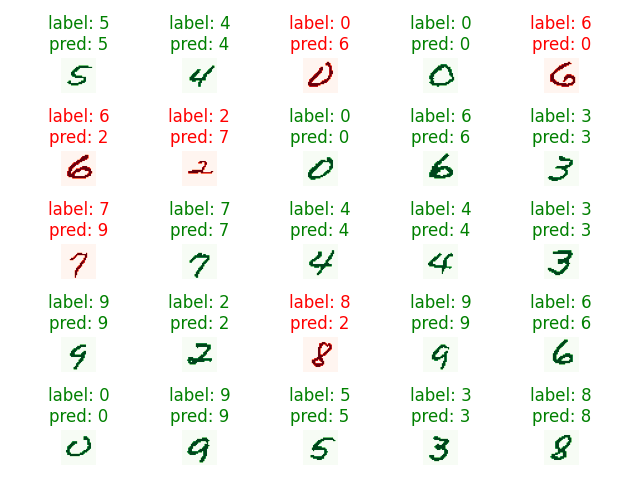

In [199]:
FIG_NAME = "preds"
plt.close(FIG_NAME)

num_plots = 25
ceil_sqrt_num_plots = np.ceil(np.sqrt(num_plots)).astype(int)

fig, axs = plt.subplots(ceil_sqrt_num_plots, ceil_sqrt_num_plots, num=FIG_NAME)
axs = np.array(axs).flatten()

for ax, in_im, in_cls, out_cls in zip(axs, input_ims, input_class, output_class):
    if in_cls == out_cls:
        c = "green"
        cmap = 'Greens'
    else:
        c = "red"
        cmap = 'Reds'
    ax.imshow(in_im, cmap=cmap)
    ax.set_title(f'label: {in_cls}\npred: {out_cls}', color=c)
    ax.axis('off')

fig.tight_layout()

plt.show()

In [200]:
TBNN.zero_grad()

In [201]:
import os
import pathlib

import bnn.save
import bnn.compress

In [202]:
schema = bnn.compress.get_schema(network=TBNN)
bWs = bnn.compress.compress_network(network=TBNN)

In [203]:
network = bnn.compress.make_network_from_schema_and_bWs(schema, bWs)
network

TernBinNetwork(
  (layers): ModuleDict(
    (TernBinLayer0): W: Parameter containing:
    tensor([[ 0,  1,  1,  ..., -1, -1,  0],
            [ 0,  1,  1,  ...,  0,  0, -1],
            [ 0,  0,  1,  ...,  0, -1,  0],
            ...,
            [ 1, -1,  1,  ...,  1, -1,  1],
            [-1, -1,  0,  ...,  0, -1,  1],
            [-1, -1, -1,  ...,  0,  0, -1]], dtype=torch.int32)
    (TernBinLayer1): W: Parameter containing:
    tensor([[-1,  0,  0,  ..., -1, -1,  0],
            [ 1, -1, -1,  ...,  1, -1, -1],
            [-1, -1,  0,  ...,  0,  1, -1],
            ...,
            [ 0, -1,  1,  ..., -1,  1, -1],
            [-1, -1,  0,  ..., -1,  0,  1],
            [ 0,  1,  1,  ...,  0, -1, -1]], dtype=torch.int32)
    (TernBinLayer2): W: Parameter containing:
    tensor([[-1, -1, -1,  ...,  0,  1,  0],
            [ 1,  1, -1,  ...,  1,  0,  1],
            [ 0, -1, -1,  ...,  0,  0,  0],
            ...,
            [-1,  1,  1,  ...,  0, -1,  1],
            [-1, -1,  1,  .

In [204]:
TBNN

TernBinNetwork(
  (layers): ModuleDict(
    (TernBinLayer0): W: Parameter containing:
    tensor([[ 0,  1,  1,  ..., -1, -1,  0],
            [ 0,  1,  1,  ...,  0,  0, -1],
            [ 0,  0,  1,  ...,  0, -1,  0],
            ...,
            [ 1, -1,  1,  ...,  1, -1,  1],
            [-1, -1,  0,  ...,  0, -1,  1],
            [-1, -1, -1,  ...,  0,  0, -1]], device='cuda:0', dtype=torch.int32)
    (TernBinLayer1): W: Parameter containing:
    tensor([[-1,  0,  0,  ..., -1, -1,  0],
            [ 1, -1, -1,  ...,  1, -1, -1],
            [-1, -1,  0,  ...,  0,  1, -1],
            ...,
            [ 0, -1,  1,  ..., -1,  1, -1],
            [-1, -1,  0,  ..., -1,  0,  1],
            [ 0,  1,  1,  ...,  0, -1, -1]], device='cuda:0', dtype=torch.int32)
    (TernBinLayer2): W: Parameter containing:
    tensor([[-1, -1, -1,  ...,  0,  1,  0],
            [ 1,  1, -1,  ...,  1,  0,  1],
            [ 0, -1, -1,  ...,  0,  0,  0],
            ...,
            [-1,  1,  1,  ...,  0, -1

In [205]:
save_dir = pathlib.Path.home() / 'tmp' / 'test' 
fname = 'test_save_5.npz'
fpath = save_dir / fname

bnn.save.save_network_compressed(network=TBNN, filename=fpath)

FileExistsError: /home/blustrini/tmp/test/test_save_5.npz already exists!

In [206]:
net = bnn.save.load_network(filename=fpath)
net

UnpicklingError: A load persistent id instruction was encountered,
but no persistent_load function was specified.

In [207]:
num_correct = 0
total = test_MNIST_loader._datapoints
for batch_id, batch in enumerate(tqdm.tqdm(test_MNIST_loader)):
    # forward pass and loss
    output_unproj = TBNN.forward_no_proj(batch.input)
    output_argmax = torch.argmax(output_unproj, dim=-1)
    target_argmax = torch.argmax(batch.target, dim=-1)

    num_correct += torch.sum(target_argmax == output_argmax)

print(f"accuracy: {num_correct / total}")

100%|██████████| 5/5 [00:00<00:00, 18.73it/s]

accuracy: 0.8222000002861023


In [208]:
k = 3
ins = torch.topk(output_unproj, k=k, dim=-1).indices
out = torch.zeros_like(output_argmax, dtype=bool)
for i in range(k):
    out |= ins[..., i] == target_argmax

torch.sum(out) / len(out)

tensor(0.9757, device='cuda:0')

In [209]:
import bnn.metrics

ds: list[bnn.random.DISCRETE_DIST | None] = []
for n, p in TBNN.named_parameters():
    if "W" in n:
        d = bnn.metrics.distribution(p.cpu())
        ds.append(d)

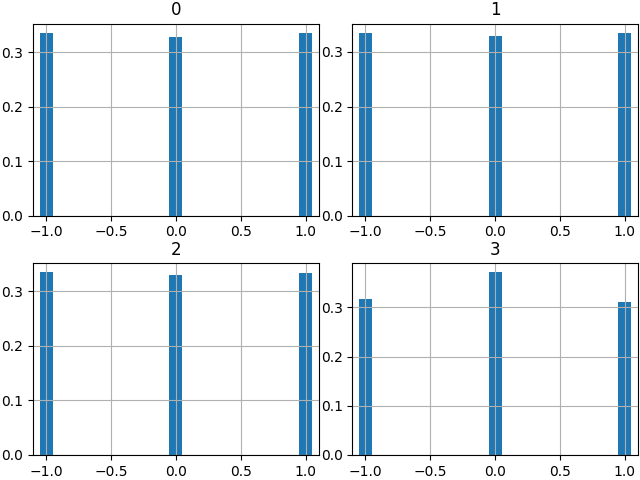

In [210]:
FIG_NAME = "dist"
plt.close(FIG_NAME)

num_plots = len(ds)
ceil_sqrt_num_plots = np.ceil(np.sqrt(num_plots)).astype(int)

fig, axs = plt.subplots(ceil_sqrt_num_plots, ceil_sqrt_num_plots, num=FIG_NAME)
axs = np.array(axs).flatten()

min_x, max_x = -1, 1
width=0.1
for i, (ax, d) in enumerate(zip(axs, ds + [None]*len(axs))):
    if d is None:
        ax.plot(np.linspace(min_x, max_x), np.linspace(0, 1), '-', color="red")
        ax.plot(np.linspace(max_x, min_x), np.linspace(0, 1), '-', color="red")
        ax.axis("off")

    else:
        ax.set_title(i)
        vals = [pair.value for pair in d]
        probs = [pair.probability for pair in d]

        if len(vals) > 3:
            ax.plot(vals, probs, 'o-')
        else:
            ax.bar(vals, probs, width=width)

        min_x = min(min_x, min(vals))
        max_x = max(max_x, max(vals))

for ax in axs:
    ax.set_xlim(min_x-width, max_x+width)
    ax.grid()

fig.tight_layout(pad=0.1)
plt.show()

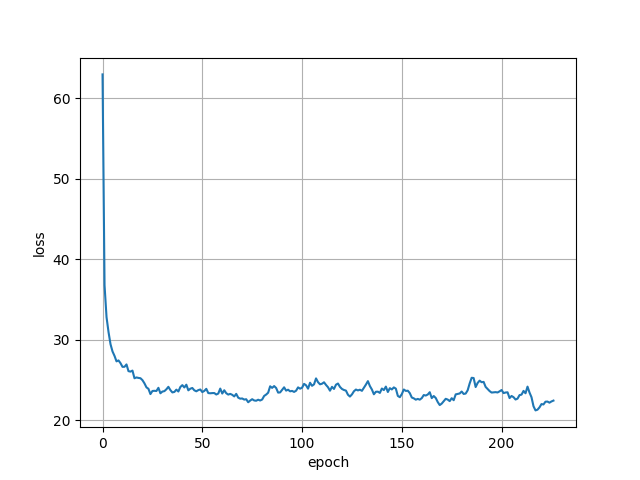

In [211]:
NAME = 'loss_curve'
plt.close(NAME)
plt.figure(NAME)

plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.show()

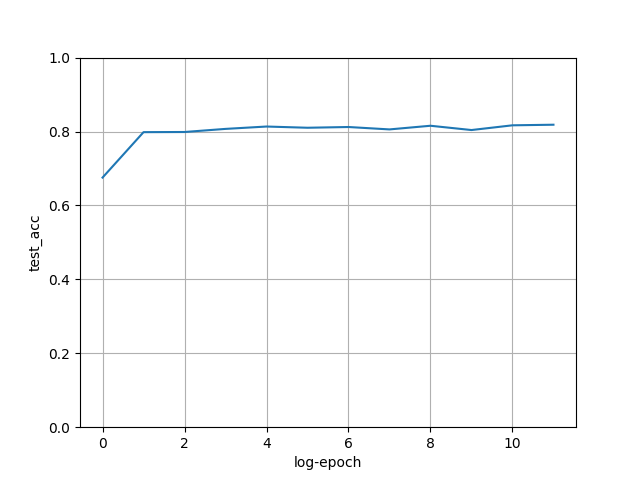

In [212]:
NAME = 'test_accs'
plt.close(NAME)
plt.figure(NAME)

plt.plot(test_accs)
plt.ylim(0, 1)
plt.xlabel('log-epoch')
plt.ylabel('test_acc')
plt.grid()

plt.show()

In [213]:
for name, p in TBNN.named_parameters():
    if name.lower().endswith('.w'):
        print(name, '\n', p, '\n', p.grad)

layers.TernBinLayer0.W 
 Parameter containing:
tensor([[ 0,  1,  1,  ..., -1, -1,  0],
        [ 0,  1,  1,  ...,  0,  0, -1],
        [ 0,  0,  1,  ...,  0, -1,  0],
        ...,
        [ 1, -1,  1,  ...,  1, -1,  1],
        [-1, -1,  0,  ...,  0, -1,  1],
        [-1, -1, -1,  ...,  0,  0, -1]], device='cuda:0', dtype=torch.int32) 
 None
layers.TernBinLayer1.W 
 Parameter containing:
tensor([[-1,  0,  0,  ..., -1, -1,  0],
        [ 1, -1, -1,  ...,  1, -1, -1],
        [-1, -1,  0,  ...,  0,  1, -1],
        ...,
        [ 0, -1,  1,  ..., -1,  1, -1],
        [-1, -1,  0,  ..., -1,  0,  1],
        [ 0,  1,  1,  ...,  0, -1, -1]], device='cuda:0', dtype=torch.int32) 
 None
layers.TernBinLayer2.W 
 Parameter containing:
tensor([[-1, -1, -1,  ...,  0,  1,  0],
        [ 1,  1, -1,  ...,  1,  0,  1],
        [ 0, -1, -1,  ...,  0,  0,  0],
        ...,
        [-1,  1,  1,  ...,  0, -1,  1],
        [-1, -1,  1,  ...,  0, -1, -1],
        [-1,  1,  1,  ..., -1, -1, -1]], device='cud

In [214]:
assert bnn.network.network_params_al_ternary(TBNN)